#New York City Tax Demand Predication

## Data

## Data Information
* Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data) The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC)

* Information on taxis:
  * Yellow Taxi: Yellow Medallion Taxicabs
      * These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

  * For Hire Vehicles (FHVs)
       * FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.

  * Green Taxi: Street Hail Livery (SHL)
    * The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.

* Credits: Quora

* Footnote:
 * In the given notebook we are considering only the yellow taxis for the time period between Jan - Mar 2015 & Jan - Mar 2016
#### Data Collection
* We Have collected all yellow taxi trips data from jan-2015 to dec-2016(Will be using only 2015 data)

* file name	file name size	number of records	number of features
    * yellow_tripdata_2016-01	1. 59G	10906858	19
    * yellow_tripdata_2016-02	1. 66G	11382049	19
    * yellow_tripdata_2016-03	1. 78G	12210952	19
    * yellow_tripdata_2015-01	1.84Gb	12748986	19
    * yellow_tripdata_2015-02	1.81Gb	12450521	19
    * yellow_tripdata_2015-03	1.94Gb	13351609	19


### Importing Libaries for the code

#### installing requried Packages

In [0]:
!pip3 install graphviz
!pip3 install dask
!pip3 install toolz
!pip3 install cloudpickle
!pip3 install gpxpy

    100% |████████████████████████████████| 112kB 4.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/f0/5e/b8e85979e66efec3eaa0e47fbc5274db99fd1a07befd1b2aa4
Successfully built gpxpy


In [0]:
import dask.dataframe as dd
import pandas as pd
import folium

import datetime
import time 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpxpy.geo

from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

#### Exporting Data from Google Drive to Googel Collab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/yellow_tripdata_2015-01.csv" "yellow_tripdata_2015-01.csv"
!cp "/content/drive/My Drive/yellow_tripdata_2016-01.csv" "yellow_tripdata_2016-01.csv"
!cp "/content/drive/My Drive/yellow_tripdata_2016-02.csv" "yellow_tripdata_2016-02.csv"
!cp "/content/drive/My Drive/yellow_tripdata_2016-03.csv" "yellow_tripdata_2016-03.csv"

####  Ran code once and saved pickle files .now Extracting all saved pickel files to once again work on code

In [0]:
!cp '/content/drive/My Drive/jan_2015_frame.pickle' 'jan_2015_frame.pickle'
!cp '/content/drive/My Drive/jan_2016_frame.pickle' 'jan_2016_frame.pickle'
!cp '/content/drive/My Drive/feb_2016_frame.pickle' 'feb_2016_frame.pickle'
!cp '/content/drive/My Drive/mar_2016_frame.pickle' 'mar_2016_frame.pickle'

!cp '/content/drive/My Drive/jan_2015_groupby.pickle' 'jan_2015_groupby.pickle'
!cp '/content/drive/My Drive/jan_2016_groupby.pickle' 'jan_2016_groupby.pickle'
!cp '/content/drive/My Drive/feb_2016_groupby.pickle' 'feb_2016_groupby.pickle'
!cp '/content/drive/My Drive/mar_2016_groupby.pickle' 'mar_2016_groupby.pickle'

### Extracting yellow_tripdata_2015-01.csv into DataFrame

In [0]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


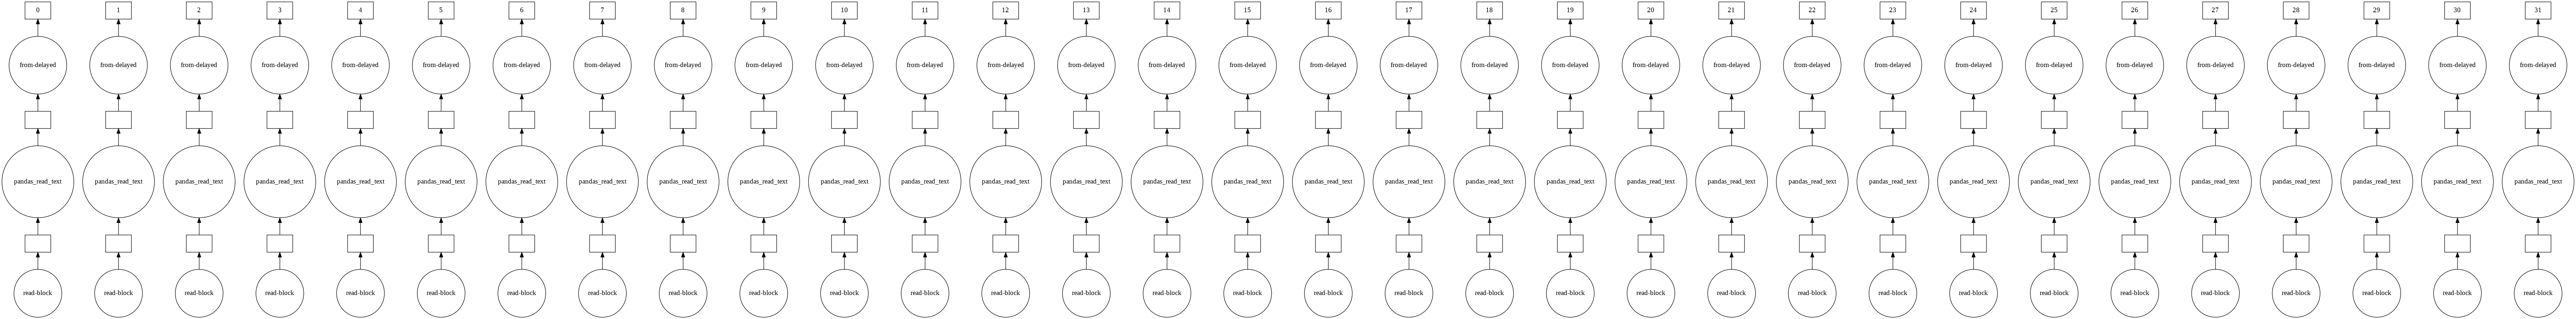

In [0]:
# However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, 
# instead they add key-value pairs to an underlying Dask graph. Recall that in the diagram below, 
# circles are operations and rectangles are results.

# to see the visulaization you need to install graphviz
# pip3 install graphviz if this doesnt work please check the install_graphviz.jpg in the drive
month.visualize()

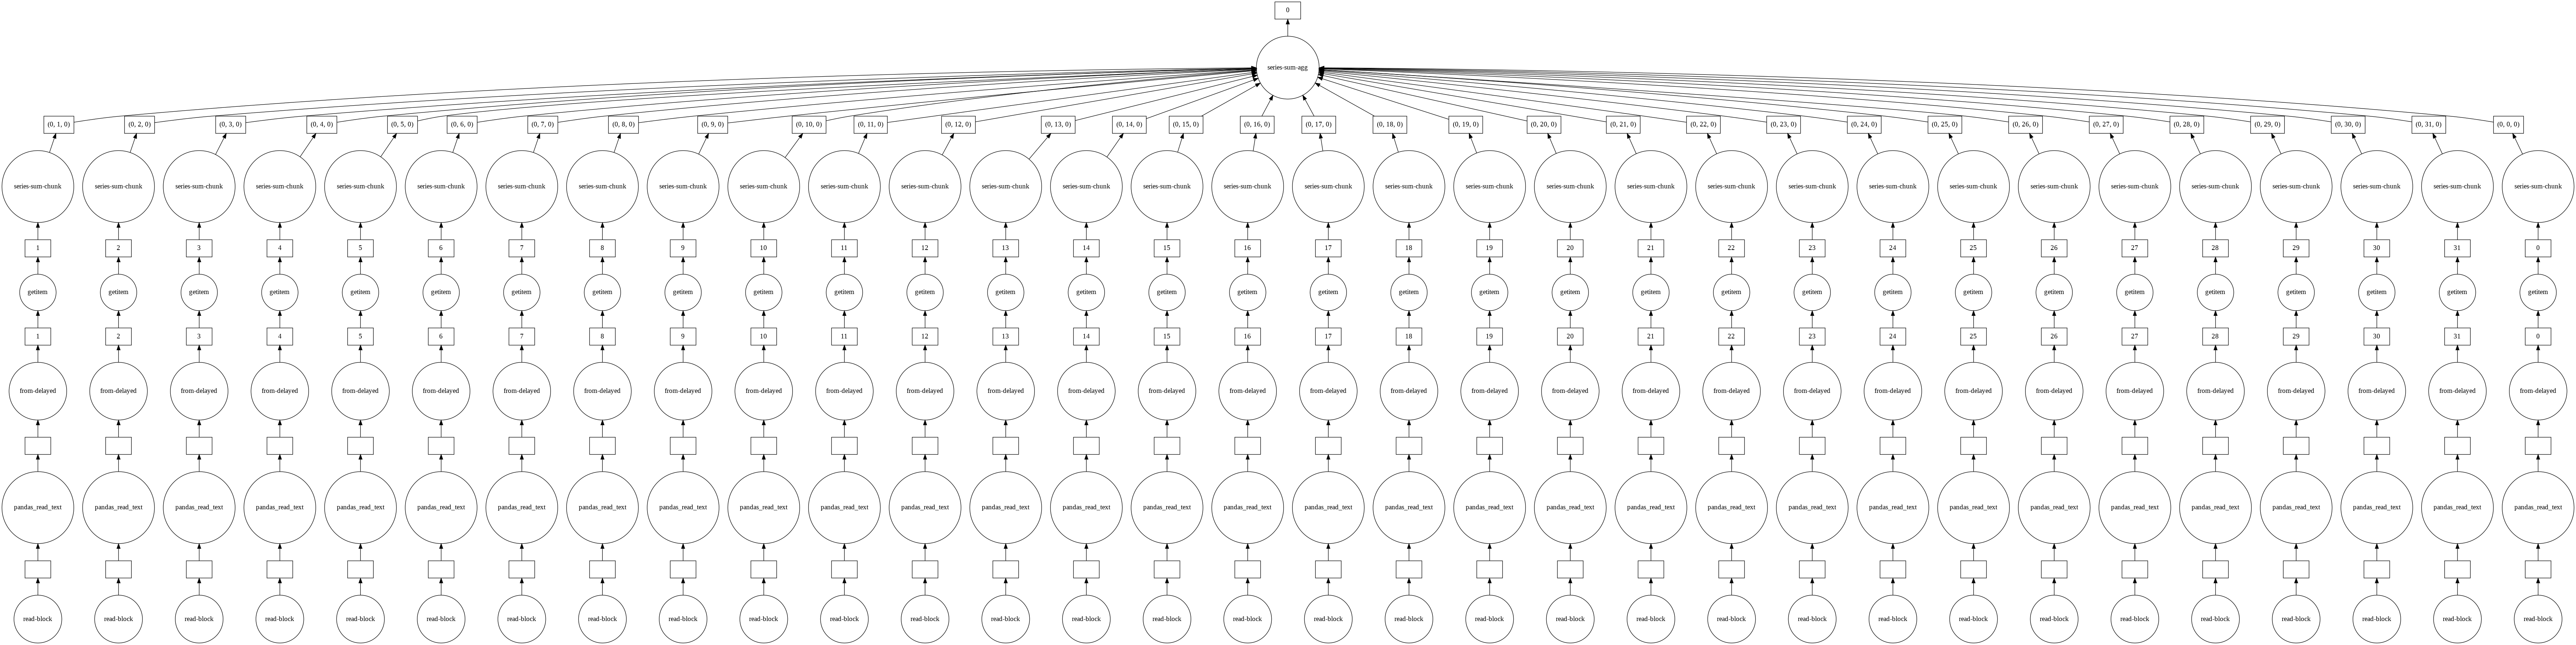

In [0]:
month.fare_amount.sum().visualize()

In [0]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


## Features in the dataset:

1.   List item

1.   List item
2.   List item


2.   List item


<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>


### Problem Statement::
- Find out the pick up density give the time and a region.
- We will be taking the data of year 2015(12 months data) as train data, and test our model on year 2016 data.(Jan,Feb,Mar data)

## ML Problem Formulation
### Time-series forecasting and Regression

*  To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.
* To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.

### Performance metrics
* Mean Absolute percentage error.
* Mean Squared error.

### Data Cleaning
In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [0]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

###  Observation:- As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude
It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [0]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

#### Observation:- The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations:
According to NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [0]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)


In [0]:

#sns.FacetGrid(frame_with_durations, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.show()

#trip_times == total duration of trip
#total_amount

#trip_distance,total_amount
#frame_with_durations['dist_amt']=frame_with_durations['trip_distance']*frame_with_durations['total_amount']
#dist_amt
frame_with_durations['total_amount'].corr(frame_with_durations['trip_distance'])

3.339064563073744e-06

In [0]:
  
frame_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378


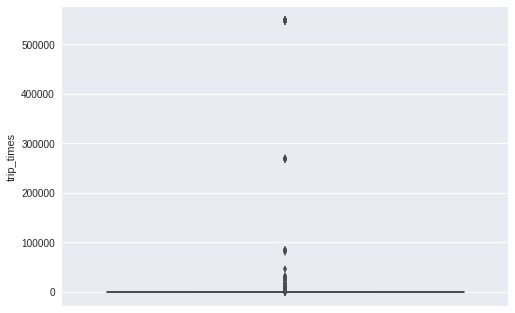

In [0]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333
90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


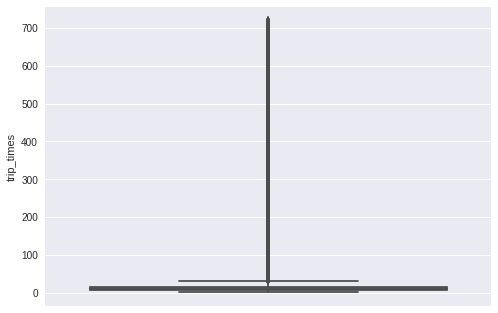

In [0]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]


#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

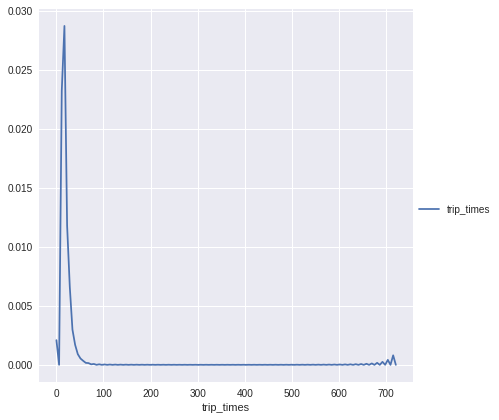

In [0]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();1
plt.show();

In [0]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

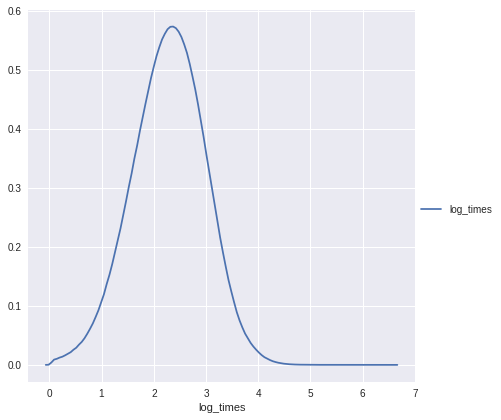

In [0]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

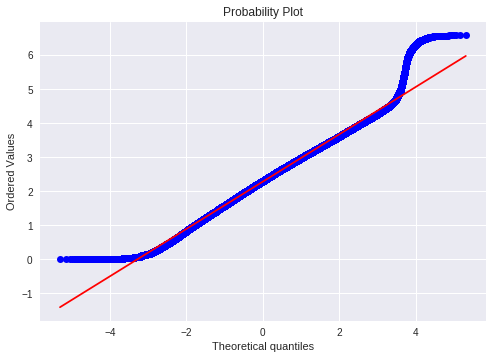

In [0]:
#Q-Q plot for checking if trip-times is log-normal
import  scipy.stats
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed


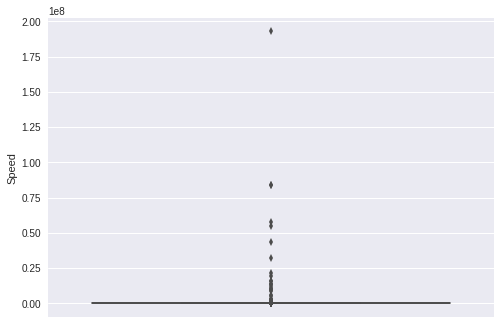

In [0]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])


#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])


#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])


#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]



0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284
90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284
99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile

In [0]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

69.52008634076317

#### The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel 2 miles per 10min on avg.

### 5. TripDistance

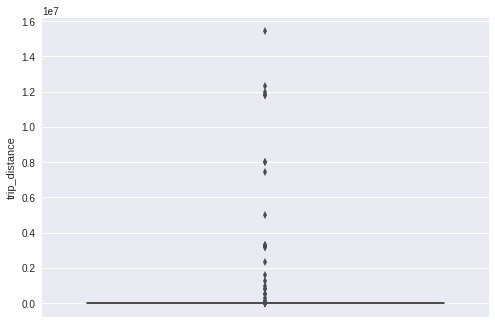

In [0]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

0 percentile value is 0.0
10 percentile value is 0.67
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.7
60 percentile value is 2.08
70 percentile value is 2.61
80 percentile value is 3.6
90 percentile value is 6.0
100 percentile value is  15420004.5
90 percentile value is 6.0
91 percentile value is 6.5
92 percentile value is 7.1
93 percentile value is 7.91
94 percentile value is 8.8
95 percentile value is 9.7
96 percentile value is 10.7
97 percentile value is 12.3
98 percentile value is 16.29
99 percentile value is 18.23
100 percentile value is  15420004.5
99.0 percentile value is 18.23
99.1 percentile value is 18.44
99.2 percentile value is 18.69
99.3 percentile value is 18.93
99.4 percentile value is 19.24
99.5 percentile value is 19.6
99.6 percentile value is 20.1
99.7 percentile value is 20.68
99.8 percentile value is 21.4
99.9 percentile value is 23.1
100 percentile value is  15420004.5


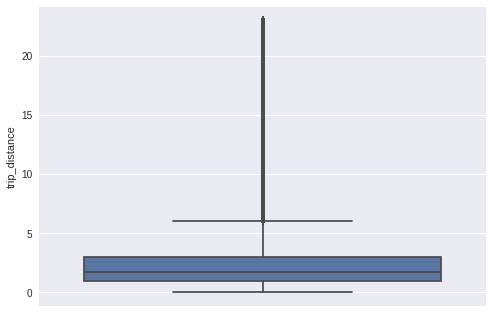

In [0]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])


#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])


#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])


#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]


#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 6.TotalFare

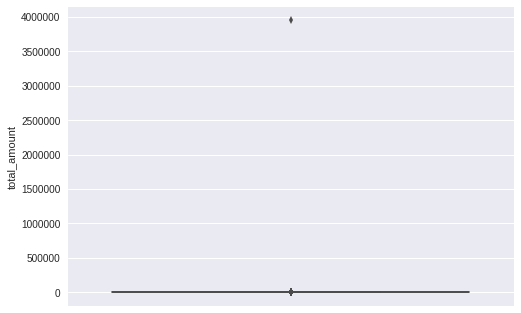

In [0]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])



#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])





0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6
90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6
99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


#### Observation:- As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

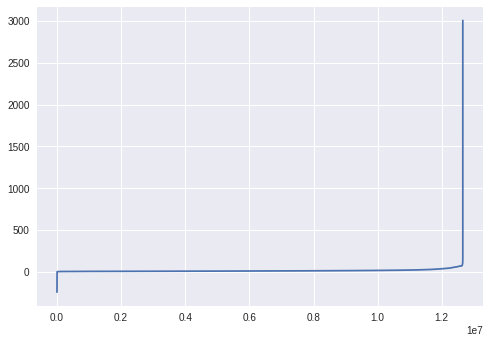

In [0]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

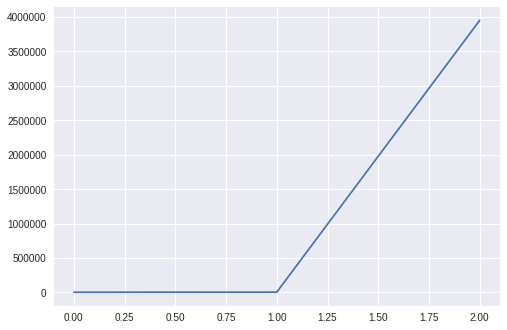

In [0]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

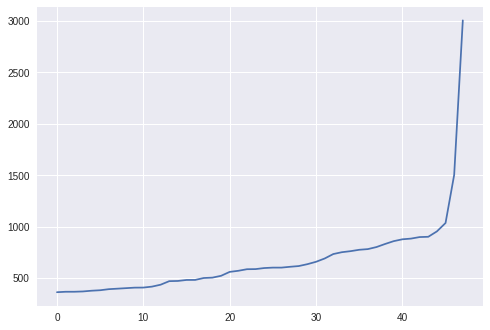

In [0]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove Outliers

In [0]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [0]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data Prepration
## Clustering/Segmentation

In [0]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142543 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007387813 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172206 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

### Inference:
* The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [0]:
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=42).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

#print(cluster_centers)
#print(cluster_len)
#frame_with_durations_outliers_removed['pickup_cluster']

In [0]:
frame_with_durations_outliers_removed['pickup_cluster'].value_counts()

0     720046
10    681187
4     672354
30    652183
18    627461
7     620722
15    619757
34    581278
6     573802
12    527936
24    499531
2     476008
11    446988
8     413783
21    397074
39    384061
20    370895
35    340682
36    329586
25    294552
16    293700
3     249610
13    247105
1     216146
37    212633
22    193258
38    176628
5      82603
9      79884
27     78863
14     68137
26     50845
32     49231
17     46157
28     34528
31     20829
19     18032
33      8963
23      8511
29      5527
Name: pickup_cluster, dtype: int64

## TimeBinning

In [0]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [0]:
frame_with_durations_outliers_removed.head(5)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,4
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,36
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,37
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,22
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,0


In [0]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
#frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [0]:
jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

trip_distance
pickup_cluster pickup_bins               
0              33                      89
               34                     190
               35                     300
               36                     289
               37                     318
               38                     320
               39                     323
               40                     326
               41                     296
               42                     300
               43                     299
               44                     275
               45                     287
               46                     270
               47                     248
               48                     219
               49                     220
               50                     196
               51                     187
               52                     195
               53                     138
               54                     132
               55                     127
               56                     115
               57                      95
               58                      97
               59                     105
               60                      64
               61                      53
               62                      52
...                                   ...
39             4467                   222
               4468                   208
               4469                   222
               4470                   185
               4471                   192
               4472                   203
               4473                   199
               4474                   183
               4475                   212
               4476                   187
               4477                   180
               4478                   213
               4479                   187
               4480                   231
               4481                   217
               4482                   262
               4483                   236
               4484                   268
               4485                   239
               4486                   259
               4487                   250
               4488                   298
               4489                   295
               4490                   310
               4491                   328
               4492                   292
               4493                   282
               4494                   290
               4495                   294
               4496                   335

[171347 rows x 1 columns]

In [0]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,4,2163
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,36,1452
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,37,1452
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,22,1452
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,0,1452


In [0]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                      23
               34                      59
               35                      56
               36                      61
               37                      68

In [0]:
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=42).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])


In [0]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

##  saving created files in pickle

In [0]:
import pickle

with open('/content/drive/My Drive/jan_2015_frame.pickle', 'wb') as handle:
    pickle.dump(jan_2015_frame, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/content/drive/My Drive/jan_2015_groupby.pickle', 'wb') as handle:
    pickle.dump(jan_2015_groupby, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
#jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
#feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
#mar_2016_frame,mar_2016_groupby

import pickle

# DUMPING a file into pickle 
with open('/content/drive/My Drive/jan_2015_frame.pickle', 'wb') as handle:
    pickle.dump(jan_2015_frame, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/jan_2016_frame.pickle', 'wb') as handle:
    pickle.dump(jan_2016_frame, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/feb_2016_frame.pickle', 'wb') as handle:
    pickle.dump(feb_2016_frame, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/mar_2016_frame.pickle', 'wb') as handle:
    pickle.dump(mar_2016_frame, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/content/drive/My Drive/jan_2015_groupby.pickle', 'wb') as handle:
    pickle.dump(jan_2015_groupby, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/jan_2016_groupby.pickle', 'wb') as handle:
    pickle.dump(jan_2016_groupby, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/feb_2016_groupby.pickle', 'wb') as handle:
    pickle.dump(feb_2016_groupby, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/mar_2016_groupby.pickle', 'wb') as handle:
    pickle.dump(mar_2016_groupby, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

#print a == b

In [0]:
import pickle

#loading pickle file in respective objects

#with open('/content/drive/My Drive/jan_2015_frame.pickle', 'rb') as handle:
#    jan_2015_frame=pickle.load(handle)
with open('/content/drive/My Drive/jan_2016_frame.pickle', 'rb') as handle:
    jan_2016_frame=pickle.load(handle)
with open('/content/drive/My Drive/feb_2016_frame.pickle', 'rb') as handle:
    feb_2016_frame=pickle.load( handle)
with open('/content/drive/My Drive/mar_2016_frame.pickle', 'rb') as handle:
    mar_2016_frame=pickle.load(handle)

    
with open('/content/drive/My Drive/jan_2015_groupby.pickle', 'rb') as handle:
    jan_2015_groupby=pickle.load(handle)
with open('/content/drive/My Drive/jan_2016_groupby.pickle', 'rb') as handle:
    jan_2016_groupby=pickle.load(handle)
with open('/content/drive/My Drive/feb_2016_groupby.pickle', 'rb') as handle:
    feb_2016_groupby=pickle.load( handle)
with open('/content/drive/My Drive/mar_2016_groupby.pickle', 'rb') as handle:
    mar_2016_groupby=pickle.load(handle)

## Smoothing

In [0]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [0]:
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)

In [0]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
#jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [0]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  26
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  150
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  33
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  426
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  42
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  50
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  22
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  32
-----------

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [0]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [0]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  178560


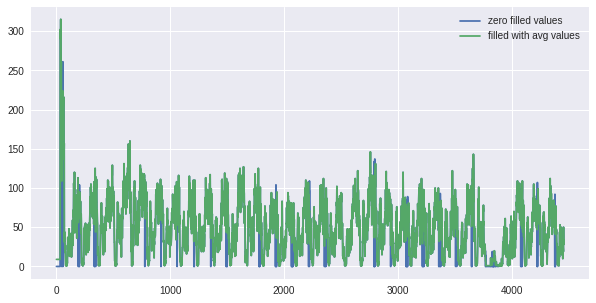

In [0]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [0]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 13104

In [0]:
import pickle

a = {'hello': 'world'}

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)


## Time series and Fourier Transforms

In [0]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

In [0]:
np.fft.fft(np.array(jan_2016_smooth)[0:4460])

array([607385.            +0.j        , -23615.53638865-22669.42531758j,
         9107.42099879+14397.36180051j, ...,
        -4920.90721595-42083.81982312j,   9107.42099879-14397.36180051j,
       -23615.53638865+22669.42531758j])

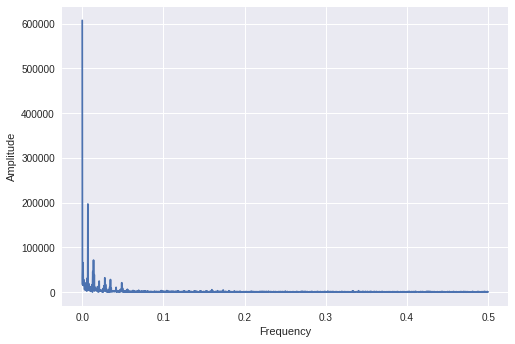

In [0]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [0]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [0]:
ratios_jan.head(2)

,Given,Prediction,Ratios
0,3,0,0.0
1,3,0,0.0


## Modelling: Baseline Models
### Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations

- Using Ratios of the 2016 data to the 2015 data i.e  𝑅𝑡=𝑉𝑎𝑙𝑢𝑒2016𝑡/𝑉𝑎𝑙𝑢𝑒2015𝑡 
- Using Previous known values of the 2016 data itself to predict the future values

### Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value 

In [0]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### Weighted Moving Averages
* The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values
* Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones

In [0]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### Exponential Moving Averages
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha  (𝛼)  which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.
For eg. If  𝛼=0.9  then the number of days on which the value of the current iteration is based is~ 1/(1−𝛼)=10  i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using  2/(𝑁+1)=0.18  ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

In [0]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### Comparison between forecasting models
We have chosen our error metric for comparison between models as MAPE (Mean Absolute Percentage Error) so that we can know that on an average how good is our model with predictions and MSE (Mean Squared Error) is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [0]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [0]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.4054893799472233       MSE:  3518.1828853046595
Moving Averages (2016 Values) -                        MAPE:  0.15465389750597616        MSE:  276.5121247759857
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.40724739950889943       MSE:  3309.3728382616487
Weighted Moving Averages (2016 Values) -               MAPE:  0.14690217992333673       MSE:  242.94073140681004
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.4127917033039604       MSE:  3329.324775985663
Exponential Moving Averages (2016 Values) -         MAPE:  0.1464448932

### Plese Note:- The above comparisons are made using Jan 2015 and Jan 2016 only

* From the above matrix it is inferred that the best forecasting model for our prediction would be:-  𝑃′𝑡=𝛼∗𝑃𝑡−1+(1−𝛼)∗𝑃′𝑡−1  i.e Exponential Moving Averages using 2016 Values

## Regression Models

### train test split
* Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [0]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [0]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [0]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [0]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [0]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [0]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [0]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [0]:
len(tsne_train_output)

366760

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [0]:
len(tsne_test_output)

157200

In [0]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [0]:
df_train.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,0,0,0,0,0,40.762761,-73.966114,4,0
1,0,0,0,0,0,40.762761,-73.966114,4,0
2,0,0,0,0,0,40.762761,-73.966114,4,0
3,0,0,0,0,0,40.762761,-73.966114,4,0
4,0,0,0,0,0,40.762761,-73.966114,4,0


In [0]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [0]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,214,212,174,203,209,40.762761,-73.966114,4,205
1,212,174,203,209,201,40.762761,-73.966114,4,202
2,174,203,209,201,238,40.762761,-73.966114,4,227
3,203,209,201,238,235,40.762761,-73.966114,4,232
4,209,201,238,235,212,40.762761,-73.966114,4,217


In [0]:
import pickle

with open('/content/drive/My Drive/df_train.pickle', 'wb') as handle:
    pickle.dump(df_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/df_test.pickle', 'wb') as handle:
    pickle.dump(df_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/tsne_train_output.pickle', 'wb') as handle:
    pickle.dump(tsne_train_output, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/tsne_test_output.pickle', 'wb') as handle:
    pickle.dump(tsne_test_output, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


In [0]:
import pickle

with open('/content/drive/My Drive/df_train.pickle', 'rb') as handle:
    df_train=pickle.load(handle)
with open('/content/drive/My Drive/df_test.pickle', 'rb') as handle:
    df_test=pickle.load( handle)
with open('/content/drive/My Drive/tsne_train_output.pickle', 'rb') as handle:
    tsne_train_output=pickle.load(handle)
with open('/content/drive/My Drive/tsne_test_output.pickle', 'rb') as handle:
    tsne_test_output=pickle.load(handle)
    

In [0]:
file1 = open("tsne_test_output.pickle",'rb')
tsne_test_output = pickle.load(file1)
file1.close()

file2 = open("tsne_train_output.pickle",'rb')
tsne_train_output = pickle.load(file2)
file2.close()

file3 = open("df_test.pickle",'rb')
df_test = pickle.load(file3)
file3.close()

file4 = open("df_train.pickle",'rb')
df_train = pickle.load(file4)
file4.close()

In [0]:
!cp '/content/drive/My Drive/tsne_test_output.pickle' 'tsne_test_output.pickle'
!cp '/content/drive/My Drive/tsne_test_output.pickle' 'tsne_train_output.pickle'
!cp '/content/drive/My Drive/tsne_test_output.pickle' 'df_test.pickle'
!cp '/content/drive/My Drive/tsne_test_output.pickle' 'df_train.pickle'


cp: cannot stat '/content/drive/My Drive/tsne_test_output.pickle': No such file or directory
cp: cannot stat '/content/drive/My Drive/tsne_test_output.pickle': No such file or directory
cp: cannot stat '/content/drive/My Drive/tsne_test_output.pickle': No such file or directory
cp: cannot stat '/content/drive/My Drive/tsne_test_output.pickle': No such file or directory


In [0]:
file4 = open("df_train.pickle",'rb')
df_train = pickle.load(file4)
file4.close()

In [0]:
len(df_train)

366760

## Linear Regression 
* Hyperparameters

In [0]:
len(df_train) ,  len(tsne_train_output)  ,  len(df_test) , len(tsne_test_output) 

(366760, 366760, 157200, 157200)

In [0]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]


from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV

lr_reg=LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg,parameters, cv=None)
grid.fit(df_train, tsne_train_output)

print(grid.best_estimator_)
print(grid.best_params_)

In [0]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
#standardizing the data using StandardScaler
df_train = StandardScaler().fit_transform(df_train)
df_test = StandardScaler().fit_transform(df_test)
    
#hyper-paramater tuning on alpha
clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
alpha = [10**-12,10**-8,10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
hyper_parameter = {"alpha": alpha}
gscv = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
gscv.fit(df_train, tsne_train_output)
alpha = gscv.best_params_["alpha"]
    
    

In [0]:
alpha

0.0001

In [0]:
#applying linear regression with best hyper-parameter
clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
clf.fit(df_train, tsne_train_output)
train_pred = clf.predict(df_train)

train_LR_MAPE = mean_absolute_error(tsne_train_output, train_pred)/ (sum(tsne_train_output)/len(df_train))
train_LR_MSE = mean_squared_error(tsne_train_output, train_pred)
  
test_pred = clf.predict(df_test)
    
test_LR_MAPE = mean_absolute_error(tsne_test_output, test_pred)/ (sum(tsne_test_output)/len(df_test))
test_LR_MSE = mean_squared_error(tsne_test_output, test_pred)

In [0]:
train_LR_MAPE,train_LR_MSE,test_LR_MAPE,test_LR_MSE

(0.14071878789100928,
 219.46245744184523,
 0.15646508399409922,
 262.51068844072165)

In [0]:
print(tsne_train_output)
print(train_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 208, 250, 250, 265, 264, 280, 256, 275, 246, 216, 235, 222, 184, 177, 177, 165, 152, 111, 132, 137, 107, 106, 101, 91, 80, 70, 58, 59, 40, 46, 39, 33, 35, 23, 29, 25, 16, 24, 19, 16, 34, 30, 10, 29, 23, 26, 32, 29, 31, 26, 25, 30, 25, 36, 46, 44, 47, 41, 60, 46, 53, 80, 64, 59, 78, 84, 77, 90, 98, 96, 100, 104, 98, 120, 125, 119, 121, 107, 128, 135, 116, 141, 140, 130, 129, 147, 110, 141, 130, 150, 132, 146, 163, 130, 180, 138, 135, 130, 149, 125, 134, 154, 162, 134, 150, 131, 151, 146, 136, 157, 141, 172, 153, 128, 118, 128, 143, 133, 108, 89, 90, 89, 102, 94, 87, 73, 87, 97, 78, 79, 76, 98, 76, 88, 78, 75, 76, 83, 54, 84, 63, 58, 67, 74, 44, 59, 52, 41, 34, 35, 42, 40, 39, 43, 37, 33, 23, 26, 27, 16, 23, 22, 21, 25, 26, 21, 31, 25, 31, 20, 20, 7, 14, 10, 12, 6, 10, 10, 19, 13, 20, 26, 24, 24, 34, 16, 18, 31, 31, 28, 41, 33, 58, 41, 55, 58, 66, 54, 50, 86, 83, 81, 102, 98, 87, 134, 128, 138, 130, 

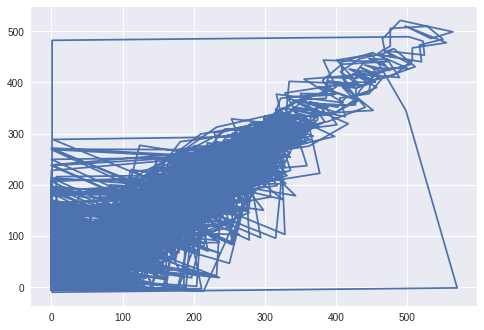

In [0]:
actual=tsne_test_output
predict=test_pred
plt.plot(actual,predict)
plt.show()

## Using LogisticRegression Fourier Trandform Features 

In [0]:

alpha=0.3
predicted_values=[]
predict_list = []
tsne_flat_exp_avg = []
freq_ampli_final = pd.DataFrame(columns= ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for r in range(0,40):
    ampliJan = np.fft.fft(np.array(regions_cum[r][0:4464]))
    freqJan = np.fft.fftfreq((4464), 1)

    
    ampliFeb = np.fft.fft(np.array(regions_cum[r])[4464:(4176+4464)])
    freqFeb = np.fft.fftfreq((4176), 1)

    
    ampliMar = np.fft.fft(np.array(regions_cum[r])[(4176+4464):(4176+4464+4464)])
    freqMar = np.fft.fftfreq((4464), 1)

    freq_ampli_jan = pd.DataFrame()
    freq_ampli_feb = pd.DataFrame()
    freq_ampli_mar = pd.DataFrame()
    
    freq_ampli_jan['Frequency'] = freqJan
    freq_ampli_jan['Amplitude'] = ampliJan
    freq_ampli_feb['Frequency'] = freqFeb
    freq_ampli_feb['Amplitude'] = ampliFeb
    freq_ampli_mar['Frequency'] = freqMar
    freq_ampli_mar['Amplitude'] = ampliMar
    
    print(freq_ampli_jan.head(3))
    print(freq_ampli_feb.head(3))
    print(freq_ampli_mar.head(3))
    
    freq_ampli_list_jan = []
    freq_ampli_list_feb = []
    freq_ampli_list_mar = []
    
    freq_ampli_jan_sorted = freq_ampli_jan.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    freq_ampli_feb_sorted = freq_ampli_feb.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    freq_ampli_mar_sorted = freq_ampli_mar.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    
    print(freq_ampli_jan_sorted.head(5))
    print(freq_ampli_feb_sorted.head(5))
    print(freq_ampli_mar_sorted.head(5))
    
    for i in range(0,5):
        freq_ampli_list_jan.append(float(freq_ampli_jan_sorted[i]['Frequency']))
        freq_ampli_list_jan.append(float(freq_ampli_jan_sorted[i]['Amplitude']))

        freq_ampli_list_feb.append(float(freq_ampli_feb_sorted[i]['Frequency']))
        freq_ampli_list_feb.append(float(freq_ampli_feb_sorted[i]['Amplitude']))

        freq_ampli_list_mar.append(float(freq_ampli_mar_sorted[i]['Frequency']))
        freq_ampli_list_mar.append(float(freq_ampli_mar_sorted[i]['Amplitude']))
        
    print(freq_ampli_list_jan[:10])

    freq_ampli_new_jan = pd.DataFrame([freq_ampli_list_jan]*4464)
    freq_ampli_new_feb = pd.DataFrame([freq_ampli_list_feb]*4176)
    freq_ampli_new_mar = pd.DataFrame([freq_ampli_list_mar]*4464)
    
    print(freq_ampli_new_jan.head(5))

    freq_ampli_new_jan.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    freq_ampli_new_feb.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    freq_ampli_new_mar.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    
    
    freq_ampli_final = freq_ampli_final.append(freq_ampli_new_jan, ignore_index=True)
    freq_ampli_final = freq_ampli_final.append(freq_ampli_new_feb, ignore_index=True)
    freq_ampli_final = freq_ampli_final.append(freq_ampli_new_mar, ignore_index=True)

    print(freq_ampli_final[:10])
    
    
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]
freq_ampli_final.drop(['f_1'],axis=1,inplace=True)

#fr_am_final = fr_am_final # (fr_am_final - fr_am_final.mean()) / (fr_am_final.max() - fr_am_final.min())
freq_ampli_final =freq_ampli_final.fillna(0)

   Frequency                                 Amplitude
0   0.000000                               (608176+0j)
1   0.000224  (-23296.07581493593-22669.648863994436j)
2   0.000448   (9289.674085934104+14643.749032794422j)
   Frequency                                  Amplitude
0   0.000000                                (617308+0j)
1   0.000239  (-3905.9598413088343-3511.3910977910973j)
2   0.000479    (-9205.888424831737+8122.319135024017j)
   Frequency                                 Amplitude
0   0.000000                               (659840+0j)
1   0.000224  (-8155.631978058274-19072.534753985296j)
2   0.000448   (8412.639076076059-10167.101445364258j)
                     0                                         1  \
Frequency           0j                 (0.006944444444444444+0j)   
Amplitude  (608176+0j)  (134113.72172125053+145886.90687057504j)   

                                                  2  \
Frequency                (-0.006944444444444444+0j)   
Amplitude  (134113.72

In [0]:
freq_ampli_final.head(3)

,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
1,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
2,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328


In [0]:
freq_ampli_final.shape

(524160, 9)

In [0]:
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [0]:
freq_ampli_final_train = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
freq_ampli_final_test = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for i in range(0,40):
    freq_ampli_final_train = freq_ampli_final_train.append(freq_ampli_final[i*13099:(13099*i+9169)] )
freq_ampli_final_train.reset_index(inplace=True)

In [0]:
freq_ampli_final_train.head(2)

,index,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,0,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
1,1,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328


In [0]:
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]
freq_ampli_final_train = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
freq_ampli_final_test = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for i in range(0,40):
    freq_ampli_final_train = freq_ampli_final_train.append(freq_ampli_final[i*13099:(13099*i+9169)] )
freq_ampli_final_train.reset_index(inplace=True)
for i in range(0,40):
    freq_ampli_final_test = freq_ampli_final_test.append(freq_ampli_final[(13099*(i))+9169:13099*(i+1)])
freq_ampli_final_test.reset_index(inplace=True)

In [0]:
len(freq_ampli_final_train),len(freq_ampli_final_test)

(366760, 157200)

In [0]:
columns=['ft_5'	,'ft_4'	,'ft_3',	'ft_2',	'ft_1',	'lat',	'lon',	'weekday'	,'exp_avg']
df_test = pd.DataFrame(data=df_test, columns=columns)
df_train = pd.DataFrame(data=df_train, columns=columns)

In [0]:
df_test_ft = pd.concat([df_test, freq_ampli_final_test], axis=1)
df_train_ft = pd.concat([df_train, freq_ampli_final_train], axis=1)

df_test_ft.head()
print(df_test.shape)
print(freq_ampli_final_test.shape)

(157200, 9)
(157200, 10)


In [0]:
df_train_ft.head(3)

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,index,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,0,0,0,0,0,40.762761,-73.966114,4,0,0,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
1,0,0,0,0,0,40.762761,-73.966114,4,0,1,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
2,0,0,0,0,0,40.762761,-73.966114,4,0,2,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328


In [0]:
# DUMPING a file into pickle 
with open('/content/drive/My Drive/df_train_ft.pickle', 'wb') as handle:
    pickle.dump(df_train_ft, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/df_test_ft.pickle', 'wb') as handle:
    pickle.dump(df_test_ft, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('/content/drive/My Drive/df_train_ft.pickle', 'rb') as handle:
    df_train_ft=pickle.load(handle)
with open('/content/drive/My Drive/df_test_ft.pickle', 'rb') as handle:
    df_test_ft=pickle.load( handle)

In [0]:
len(df_test_ft) , len(df_train_ft)

(157200, 366760)

In [0]:
df_train_ft.head(3)

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,index,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,0,0,0,0,0,40.762761,-73.966114,4,0,0,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
1,0,0,0,0,0,40.762761,-73.966114,4,0,1,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328
2,0,0,0,0,0,40.762761,-73.966114,4,0,2,608176.0,0.006944,134113.721721,-0.006944,134113.721721,-0.013889,26238.619328,0.013889,26238.619328


#### now LR Model Algo using Additional Fourier TransformFeatures

In [0]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
#standardizing the data using StandardScaler
df_train_ft = StandardScaler().fit_transform(df_train_ft)
df_test_ft = StandardScaler().fit_transform(df_test_ft)
    
#hyper-paramater tuning on alpha
clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
alpha = [10**-12,10**-8,10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
hyper_parameter = {"alpha": alpha}
gscv = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
gscv.fit(df_train_ft, tsne_train_output)
alpha = gscv.best_params_["alpha"]
    
print("alpha value is : ",alpha)    

alpha value is :  1e-06


In [0]:
#applying linear regression with best hyper-parameter
clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
clf.fit(df_train_ft, tsne_train_output)
train_pred = clf.predict(df_train_ft)

train_FT_LR_MAPE = mean_absolute_error(tsne_train_output, train_pred)/ (sum(tsne_train_output)/len(df_train))
train_FT_LR_MSE = mean_squared_error(tsne_train_output, train_pred)
  
test_pred = clf.predict(df_test_ft)
    
test_FT_LR_MAPE = mean_absolute_error(tsne_test_output, test_pred)/ (sum(tsne_test_output)/len(df_test))
test_FT_LR_MSE = mean_squared_error(tsne_test_output, test_pred)

print(train_FT_LR_MAPE)
print(test_FT_LR_MAPE)

print(train_FT_LR_MSE)
print(test_FT_LR_MSE)

0.14207404983517993
0.1596219392838245
220.23902704407797
257.3198145201902


## Using Random Forest Regressor

In [0]:
from sklearn.model_selection import GridSearchCV  
#hyper-paramater tuning
n_estimator = [10, 100 , 200 , 300]
clf = RandomForestRegressor(n_jobs = -1)
hyper_parameter = {"n_estimators": n_estimator}
gscv_RF = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
gscv_RF.fit(df_train, tsne_train_output)
estimators = gscv_RF.best_params_["n_estimators"]
 
print("estimators value is : ",estimators)


estimators value is :  300


In [0]:
clf = RandomForestRegressor(n_estimators = 300, n_jobs = -1)
clf.fit(df_train, tsne_train_output)
train_RF_pred = clf.predict(df_train)

train_RF_MAPE = mean_absolute_error(tsne_train_output, train_RF_pred)/ (sum(tsne_train_output)/len(df_train))
train_RF_MSE = mean_squared_error(tsne_train_output, train_RF_pred)
  
test_RF_pred = clf.predict(df_test)
    
test_RF_MAPE = mean_absolute_error(tsne_test_output, test_RF_pred)/ (sum(tsne_test_output)/len(df_test))
test_RF_MSE = mean_squared_error(tsne_test_output, test_RF_pred)

In [0]:
print(train_RF_MAPE  , test_RF_MAPE , train_RF_MSE  , test_RF_MSE )

0.05289541506658563 0.13345387634280537 34.047573562646086 215.07768159445646


In [0]:
clf.fit(df_train, tsne_train_output)
train_pred = clf.predict(df_train)

train_RF_MAPE = mean_absolute_error(tsne_train_output, train_pred)/ (sum(tsne_train_output)/len(df_train))
train_RF_MSE = mean_squared_error(tsne_train_output, train_pred)
  
test_pred = clf.predict(df_test)
    
test_RF_MAPE = mean_absolute_error(tsne_test_output, test_pred)/ (sum(tsne_test_output)/len(df_test))
test_RF_MSE = mean_squared_error(tsne_test_output, test_pred)

In [0]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (clf.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.14996591 0.10633947 0.11247443 0.11860941 0.14928426 0.05112474
 0.0593047  0.02113156 0.23176551]


#### RandomForest Algo with Derived Features + Fourier Tansform Features

In [0]:
clf = RandomForestRegressor(n_estimators = 300, n_jobs = -1)
clf.fit(df_train_ft, tsne_train_output)
train_RF_pred = clf.predict(df_train_ft)

train_FT_RF_MAPE = mean_absolute_error(tsne_train_output, train_RF_pred)/ (sum(tsne_train_output)/len(df_train))
train_FT_RF_MSE = mean_squared_error(tsne_train_output, train_RF_pred)
  
test_RF_pred = clf.predict(df_test_ft)
    
test_FT_RF_MAPE = mean_absolute_error(tsne_test_output, test_RF_pred)/ (sum(tsne_test_output)/len(df_test))
test_FT_RF_MSE = mean_squared_error(tsne_test_output, test_RF_pred)

In [0]:
print(train_FT_RF_MAPE  , test_FT_RF_MAPE , train_FT_RF_MSE  , test_FT_RF_MSE )

0.05117624245481564 0.1391061161105259 29.16950382057295 243.18204304247948


## Using XgBoost Regressor

In [0]:
#hyper-parameter tuning
hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators":[ 50, 100, 200 , 300, 500 ,800]}
clf = xgb.XGBRegressor()
gscv_XGboost = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
gscv_XGboost.fit(df_train, tsne_train_output)
estimators = gscv_XGboost.best_params_["n_estimators"]
depth = gscv_XGboost.best_params_["max_depth"]

In [0]:
   
#applying xgboost regressor with best hyper-parameter
clf = xgb.XGBRegressor(max_depth = 3, n_estimators = 300)
clf.fit(df_train, tsne_train_output)
train_pred = clf.predict(df_train)

train_XG_MAPE = mean_absolute_error(tsne_train_output, train_pred)/ (sum(tsne_train_output)/len(df_train))
train_XG_MSE = mean_squared_error(tsne_train_output, train_pred)
  
test_pred = clf.predict(df_test)
    
test_XG_MAPE = mean_absolute_error(tsne_test_output, test_pred)/ (sum(tsne_test_output)/len(df_test))
test_XG_MSE = mean_squared_error(tsne_test_output, test_pred)

In [0]:
train_XG_MAPE , test_XG_MAPE , train_XG_MSE , test_XG_MSE

(0.1375477342262253,
 0.13206225680544467,
 200.24432745666732,
 210.07724668524213)

In [0]:
print(clf.feature_importances_)
columns=df_train.columns.tolist()
index=np.argsort(clf.feature_importances_)[::-1]
important_features=[columns[i] for i in index]
important_features

[0.17395483 0.10667948 0.12109563 0.1283037  0.17635752 0.06006727
 0.07063912 0.01537722 0.14752522]


['ft_1', 'ft_5', 'exp_avg', 'ft_2', 'ft_3', 'ft_4', 'lon', 'lat', 'weekday']

#### XGBoost with Derived Features + Fourier Tansform Features

In [0]:
   
#applying xgboost regressor with best hyper-parameter
clf = xgb.XGBRegressor(max_depth = 3, n_estimators = 300)
clf.fit(df_train_ft, tsne_train_output)
train_pred = clf.predict(df_train_ft)

train_FT_XG_MAPE = mean_absolute_error(tsne_train_output, train_pred)/ (sum(tsne_train_output)/len(df_train))
train_FT_XG_MSE = mean_squared_error(tsne_train_output, train_pred)
  
test_pred = clf.predict(df_test_ft)
    
test_FT_XG_MAPE = mean_absolute_error(tsne_test_output, test_pred)/ (sum(tsne_test_output)/len(df_test))
test_FT_XG_MSE = mean_squared_error(tsne_test_output, test_pred)

In [0]:
train_FT_XG_MAPE,test_FT_XG_MAPE,train_FT_XG_MSE,test_FT_XG_MSE

(0.13718241594863337,
 0.1495687219544933,
 198.49282181632196,
 245.5039932718171)

In [0]:
print(clf.feature_importances_)
columns=df_train_ft.columns.tolist()
#columns
index=np.argsort(clf.feature_importances_)[::-1]
important_features=[columns[i] for i in index]
print(important_features)

[0.15918958 0.10130246 0.10998553 0.12397491 0.15050651 0.01447178
 0.03039074 0.00868307 0.14037627 0.06705258 0.04389773 0.02701399
 0.00916546 0.         0.         0.00434153 0.00964785 0.
 0.        ]
['ft_5', 'ft_1', 'exp_avg', 'ft_2', 'ft_3', 'ft_4', 'index', 'a_1', 'lon', 'f_2', 'lat', 'a_4', 'a_2', 'weekday', 'f_4', 'f_5', 'f_3', 'a_3', 'a_5']


## Comparsion

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

print("RandomForest Table")
x.field_names = ['Algo','Test_MAPE','Test_MSE']

x.add_row(['Moving_Averages_usingRatios', 0.405489 , 3518.1828])
x.add_row(['Moving_Averages_usingPrevious', 0.154653 , 276.5121])
x.add_row(['Weighted_Moving_Averages_usingRatios', 0.4072 , 3309.3728])
x.add_row(['Weighted_Moving_Averages_usingPrevious', 0.14690 , 242.940])
x.add_row(['Exponential_Moving_Averages_usingRatios', 0.41279 , 3329.324])
x.add_row(['Exponential_Moving_Averages_usingPrevious', 0.14644 , 240.18717])
x.add_row(['--------------------------','---------','------------'])

x.add_row(['LinearRegression', 0.156465 , 262.5106])
x.add_row(['LinearRegression_FT', 0.159621 ,257.31981])
x.add_row(['RandomRegressor',0.133453,215.07768])
x.add_row(['RandomRegressor_FT',0.139106,243.18204])
x.add_row(['XGBoostRegressor',0.132060,210.0772])
x.add_row(['XGBoostRegressor_FT',0.149568,245.5039])


print(x)

RandomForest Table
+-------------------------------------------+-----------+--------------+
|                    Algo                   | Test_MAPE |   Test_MSE   |
+-------------------------------------------+-----------+--------------+
|        Moving_Averages_usingRatios        |  0.405489 |  3518.1828   |
|       Moving_Averages_usingPrevious       |  0.154653 |   276.5121   |
|    Weighted_Moving_Averages_usingRatios   |   0.4072  |  3309.3728   |
|   Weighted_Moving_Averages_usingPrevious  |   0.1469  |    242.94    |
|  Exponential_Moving_Averages_usingRatios  |  0.41279  |   3329.324   |
| Exponential_Moving_Averages_usingPrevious |  0.14644  |  240.18717   |
|         --------------------------        | --------- | ------------ |
|              LinearRegression             |  0.156465 |   262.5106   |
|            LinearRegression_FT            |  0.159621 |  257.31981   |
|              RandomRegressor              |  0.133453 |  215.07768   |
|             RandomRegressor_FT

In [0]:
algo=['Moving_Averages_usingRatios','Moving_Averages_usingPrevious','Weighted_Moving_Averages_usingRatios','Weighted_Moving_Averages_usingPrevious','Exponential_Moving_Averages_usingRatios','Exponential_Moving_Averages_usingPrevious','LinearRegression','LinearRegression_FT','RandomRegressor','RandomRegressor_FT','XGBoostRegressor','XGBoostRegressor_FT']

Test_MAPE=[0.405489,0.154653 , 0.4072,0.14690 ,0.41279,0.14644,0.156465,0.159621,0.133453,0.139106,0.13206,0.14956]
Test_MSE = [3518.1828,276.51,3309.37,242.9,3329.32,240.18,262.5106,257.3198,215.077,243.182,210.077,245.50]


import pandas as pd
Results=pd.DataFrame({"algorithm" : algo , "Test_MAPE" : Test_MAPE , "Test_MSE" :Test_MSE})
Results

,Test_MAPE,Test_MSE,algorithm
0,0.405489,3518.1828,Moving_Averages_usingRatios
1,0.154653,276.5100,Moving_Averages_usingPrevious
2,0.407200,3309.3700,Weighted_Moving_Averages_usingRatios
3,0.146900,242.9000,Weighted_Moving_Averages_usingPrevious
4,0.412790,3329.3200,Exponential_Moving_Averages_usingRatios
5,0.146440,240.1800,Exponential_Moving_Averages_usingPrevious
6,0.156465,262.5106,LinearRegression
7,0.159621,257.3198,LinearRegression_FT
8,0.133453,215.0770,RandomRegressor
9,0.139106,243.1820,RandomRegressor_FT


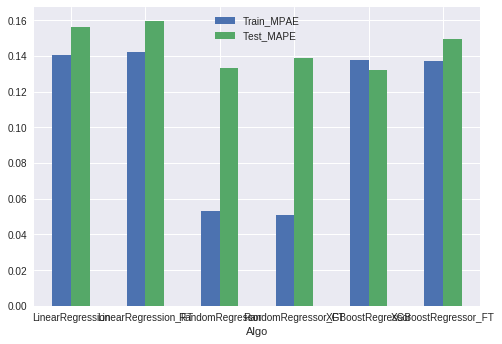

In [0]:
Resultdata=[['LinearRegression',0.140718,0.1564650],
['LinearRegression_FT', 0.142074, 0.15962],
['RandomRegressor',0.052895, 0.133453],
['RandomRegressor_FT',0.051176, 0.139106],
['XGBoostRegressor',0.137547,0.132066],
['XGBoostRegressor_FT',0.137182,0.149568]]

df=pd.DataFrame(Resultdata,columns=['Algo','Train_MPAE','Test_MAPE'],index=df['Algo'])
df

ax = df.plot.bar(rot=0)

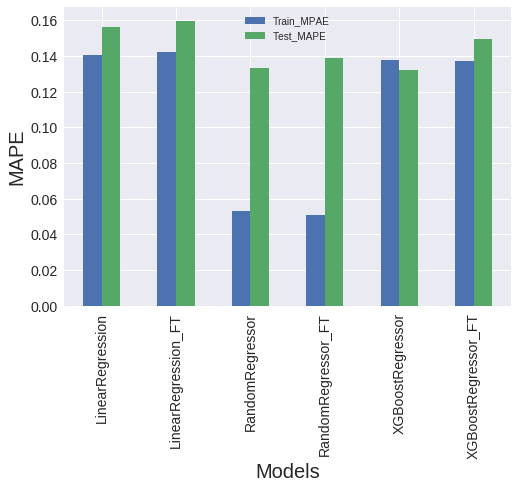

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

Resultdata=[['LinearRegression',0.140718,0.1564650],
['LinearRegression_FT', 0.142074, 0.15962],
['RandomRegressor',0.052895, 0.133453],
['RandomRegressor_FT',0.051176, 0.139106],
['XGBoostRegressor',0.137547,0.132066],
['XGBoostRegressor_FT',0.137182,0.149568]]

a=pd.DataFrame(Resultdata,columns=['Algo','Train_MPAE','Test_MAPE'])
a.set_index('Algo', inplace=True)
a.plot(kind='bar')
plt.xlabel("Models",fontsize=20)
plt.ylabel("MAPE",fontsize=20)
plt.xticks(fontsize=14) #rotation=90)
plt.yticks(fontsize=14)

plt.show()



Problem :
  - predicting number of pickups for taxi  for a particular time in NewYorkCity
  - so this is a TimeSeries problem
  - pickup values ie ouput may vary from 0 to any_no_of_values ie [0,any_no_of_values ]
  - so thisis Regression problem
  - so your problem is TimeSeriesRegression problem
  
Prepration of Data :
 -  had Done Exploratory data Analysis to check any features plays good amount of role to find no of pickups
 - since this is time series predication problem  ie finding no.of.pickups at a particular time at a particular region
 - so  divided our data into regions depending upon latitude and longitude features using clustering technique
 - and  decided to take  10mints time interval to find no.of pickups so, for every 10 mints we found the no.of pickups
 - so now for every Region (cluster) for every 10 mints found the no.of.cluster
 - so for every region we have total 13104 bins
    - ie example jan month :: number of 10min indices for jan 2015= 24*31*60/10 = 4464 
    - like that  feb(4176),mar(4464)
    - so for 3 months total (4464+4176+4464) bins
- after that we divided data into 70-30 ratio . 70% train data , 30% testdata
- for that data we consider some useful features for each cluster
- now considerd  each cluster data and put at one place so now we had(9169*40) Train data points and (3929*40) test datapoints
- now consider that data and build the ML models


# Conclusion ::
- Among all the models Xgboost Regressor and RandomForest Regressor models results are nearly similar  but XGBoost Performs Slightly better than RandomForest Regressor
- even though we are not performing any machine learning model and prepared Complex timeseriesdata ExponentialMOving WeightedAverage performing better

